# Negative Binomial Regression

## Negative binomial distribution review

I always experience some kind of confusion when looking at the negative binomial distribution after a while of not working with it. There are so many different definitions that I usually need to read everything more than once. The definition I've first learned, and the one I like the most, says as follows: The negative binomial distribution is the distribution of a random variable that is defined as the number of independent Bernoulli trials until the k-th "success". In short, we repeat a Bernoulli experiment until we observe k  successes and record the number of trials it required.

$$
Y \sim \text{NB}(k, p)
$$

where $0 \le p \le 1$ is the probability of success in each Bernoulli trial, $k > 0$, usually integer, and $y \in \{k, k + 1, \cdots\}$

The probability mass function (pmf) is 

$$
p(y | k, p)= \binom{y - 1}{y-k}(1 -p)^{y - k}p^k
$$

If you, like me, find it hard to remember whether $y$ starts at $0$, $1$, or $k$, try to think twice about the definition of the variable. But how? First, recall we aim to have $k$ successes. And success is one of the two possible outcomes of a trial, so the number of trials can never be smaller than the number of successes. Thus, we can be confident to say that $y \ge k$.

But this is not the only way of defining the negative binomial distribution, there are plenty of options! One of the most interesting, and the one you see in [PyMC3](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.NegativeBinomial), the library we use in Bambi for the backend, is as a continuous mixture. The negative binomial distribution describes a Poisson random variable whose rate is also a random variable (not a fixed constant!) following a gamma distribution. Or in other words, conditional on a gamma-distributed variable $\mu$, the variable $Y$ has a Poisson distribution with mean $\mu$.

Under this alternative definition, the pmf is

$$
\displaystyle p(y | k, \alpha) = \binom{y + \alpha - 1}{y} \left(\frac{\alpha}{\mu + \alpha}\right)^\alpha\left(\frac{\mu}{\mu + \alpha}\right)^y
$$

where $\mu$ is the parameter of the Poisson distribution (the mean, and variance too!) and $\alpha$ is the rate parameter of the gamma.

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import nbinom

In [2]:
az.style.use("arviz-darkgrid")

In SciPy, the definition of the negative binomial distribution differs a little from the one in our introduction. They define $Y$ = Number of failures until k sucesses and then $y$ starts at 0. In the following plot, we have  the probability of observing $y$ failures before we see $k=3$ successes. 

In [3]:
y = np.arange(0, 30)
k = 3
p1 = 0.5
p2 = 0.3

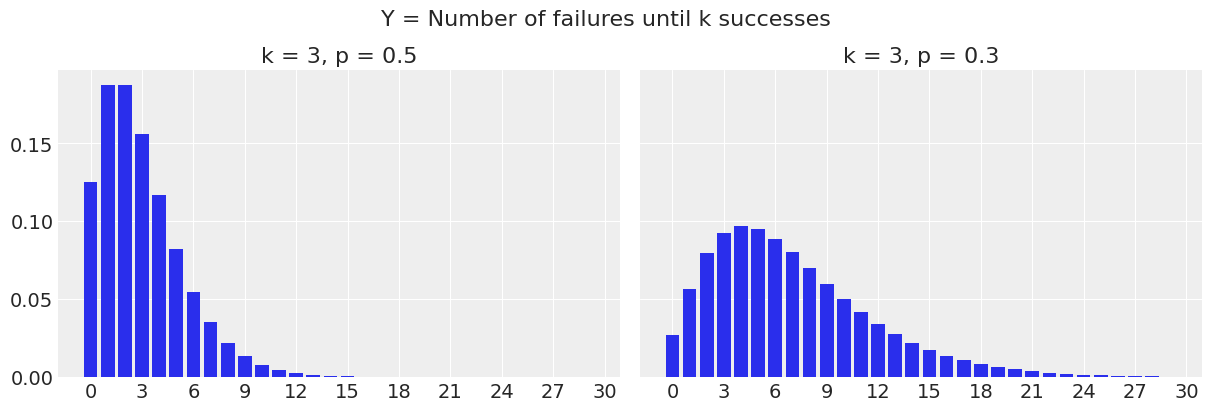

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax[0].bar(y, nbinom.pmf(y, k, p1))
ax[0].set_xticks(np.linspace(0, 30, num=11))
ax[0].set_title(f"k = {k}, p = {p1}")

ax[1].bar(y, nbinom.pmf(y, k, p2))
ax[1].set_xticks(np.linspace(0, 30, num=11))
ax[1].set_title(f"k = {k}, p = {p2}")

fig.suptitle("Y = Number of failures until k successes", fontsize=16);

For example, when $p=0.5$, the probability of seeing $y=0$ failures before 3 successes (or in other words, the probability of having 3 successes out of 3 trials) is 0.125, and the probability of seeing $y=3$ failures before 3 successes is 0.156.

In [5]:
print(nbinom.pmf(y, k, p1)[0])
print(nbinom.pmf(y, k, p1)[3])

0.12500000000000003
0.15625000000000003


Finally, if one wants to show this probability mass function as if we are following the first definition of negative binomial distribution we introduced, we just need to shift the whole thing to the right by adding $k$ to the $y$ values.

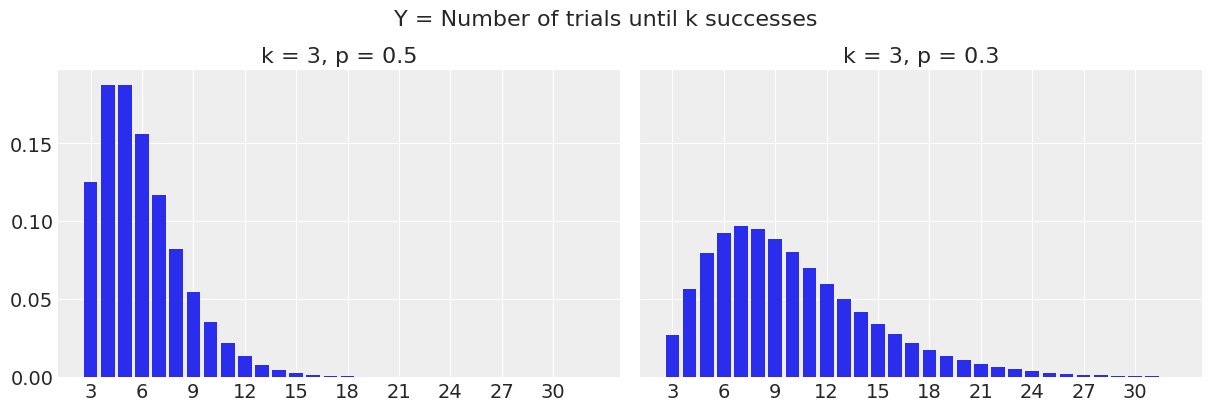

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax[0].bar(y + k, nbinom.pmf(y, k, p1))
ax[0].set_xticks(np.linspace(3, 30, num=10))
ax[0].set_title(f"k = {k}, p = {p1}")

ax[1].bar(y + k, nbinom.pmf(y, k, p2))
ax[1].set_xticks(np.linspace(3, 30, num=10))
ax[1].set_title(f"k = {k}, p = {p2}")

fig.suptitle("Y = Number of trials until k successes", fontsize=16);

## Negative binomial in GLM

The negative binomial distribution belongs to the exponential family, and the canonical link function is 

$$
g(\mu_i) = \log\left(\frac{\mu_i}{k + \mu_i}\right) = \log\left(\frac{k}{\mu_i} + 1\right)
$$

but it is difficult to interpret. The log link is usually preferred because of the analogy with Poisson model, and it also tends to give better results.

## Load and explore Cells data

In this example we use a data set taken from [Multivariate Statistical Modelling Based on Generalized Linear Models](https://www.springer.com/gp/book/9781489900104) by Ludwig Fahrmeir and Gerhard Tutz.

The effect of two agents of immuno-activating ability that may induce cell differentiation was investigated. As response variable the number of cells that exhibited markers after exposure was recorded. It is of interest if the agents TNF (tumor necrosis factor) and IFN (interferon) stimulate cell differentiation independently, or if there is a synergetic effect. 200 cells were examined at each dose combination.

The dataset contains 16 observations and 3 variables:

* **y** number of cells differentiating
* **TNF** dose of TNF, U/ml
* **IFN** dose of IFN, U/ml

And the following model is proposed

$$
\mu_i = \exp{\left( \beta_0  + \beta_1\text{TNF} + \beta_2\text{IFN} + \beta_3\text{TNF}\times\text{IFN}\right)}
$$

In [7]:
data = pd.read_csv("data/cells.csv")
data.head()

,y,TNF,IFN
0,11,0,0
1,18,0,4
2,20,0,20
3,39,0,100
4,22,1,0


Here we use `scale()`, a built-in function in the formula interface, that standardizes the variable we pass to it, because the sampler failed to start when we attempted to fit the model without scaling the variables.

In [8]:
model = bmb.Model("y ~ scale(TNF)*scale(IFN)", data, family="negativebinomial")
model

Formula: y ~ scale(TNF)*scale(IFN)
Family name: Negativebinomial
Link: log
Observations: 16
Priors:
  Intercept ~ Normal(mu: 4.32661302, sigma: 1.00658443)
  scale(TNF) ~ Normal(mu: 0, sigma: 0.59016587)
  scale(IFN) ~ Normal(mu: 0, sigma: 0.58600849)
  scale(TNF):scale(IFN) ~ Normal(mu: 0, sigma: 0.62181517)
  alpha ~ HalfCauchy(beta: 1)

In [9]:
fitted = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_alpha, scale(TNF):scale(IFN), scale(IFN), scale(TNF), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [10]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.127,0.137,3.857,4.375,0.003,0.002,1897.0,1353.0,1.0
scale(TNF),0.588,0.137,0.343,0.848,0.003,0.002,1991.0,1321.0,1.0
scale(IFN),0.313,0.138,0.060,0.571,0.003,0.003,1837.0,1294.0,1.0
scale(TNF):scale(IFN),-0.083,0.139,-0.329,0.192,0.003,0.003,1772.0,1329.0,1.0
y_alpha,4.218,1.888,1.324,7.781,0.062,0.046,1040.0,790.0,1.0


In [11]:
b_0 = fitted.posterior["Intercept"].squeeze().values.reshape(-1,)
b_tnf = fitted.posterior["scale(TNF)"].squeeze().values.reshape(-1,)
b_ifn = fitted.posterior["scale(IFN)"].squeeze().values.reshape(-1,)
b_tnf_ifn = fitted.posterior["scale(TNF):scale(IFN)"].squeeze().values.reshape(-1,)

In [12]:
y_hat = []
tnf_vals = np.arange(0, 101)
ifn_vals = np.array([0, 4, 20, 100])

for idx, ifn in enumerate(ifn_vals):
    new_data = pd.DataFrame({"TNF": tnf_vals, "IFN": np.array([ifn] * len(tnf_vals))})
    X = model._design.common._evaluate_new_data(new_data).design_matrix
    y_hat.append(np.exp(np.dot(X, np.vstack([b_0, b_tnf, b_ifn, b_tnf_ifn]))))

mu_pred = [y.mean(1) for y in y_hat]

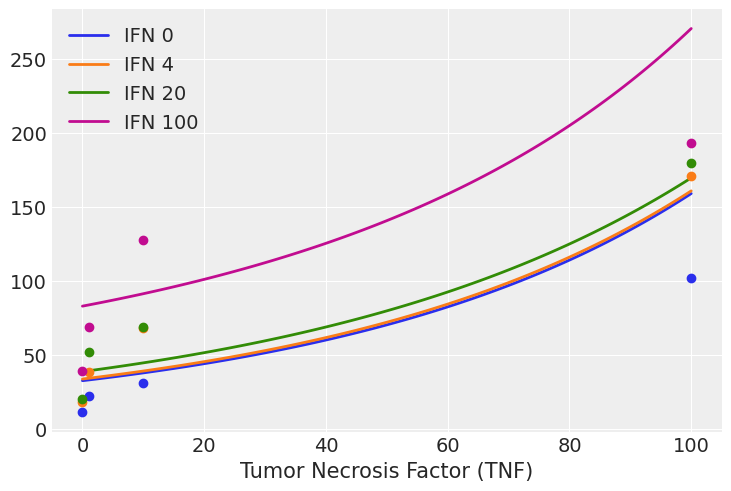

In [13]:
fig, ax = plt.subplots()

for i, (ifn, mu) in enumerate(zip(ifn_vals, mu_pred)):
    ax.plot(tnf_vals, mu, label=f"IFN {ifn}", color=f"C{i}", lw=2)

for i, ifn in enumerate(ifn_vals):
    data_ = data[data["IFN"] == ifn]
    plt.plot(data_["TNF"], data_["y"], "o", color=f"C{i}")
    
ax.set_xlabel("Tumor Necrosis Factor (TNF)")
ax.legend(loc="upper left");

In [14]:
model_2 = bmb.Model("y ~ np.log(TNF + 1)*np.log(IFN + 1)", data, family="negativebinomial")
model_2

Formula: y ~ np.log(TNF + 1)*np.log(IFN + 1)
Family name: Negativebinomial
Link: log
Observations: 16
Priors:
  Intercept ~ Normal(mu: 4.32661302, sigma: 2.10130399)
  np.log(TNF + 1) ~ Normal(mu: 0, sigma: 0.55558467)
  np.log(IFN + 1) ~ Normal(mu: 0, sigma: 0.51776082)
  np.log(TNF + 1):np.log(IFN + 1) ~ Normal(mu: 0, sigma: 0.20248065)
  alpha ~ HalfCauchy(beta: 1)

In [15]:
fitted_2 = model_2.fit(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_alpha, np.log(TNF + 1):np.log(IFN + 1), np.log(IFN + 1), np.log(TNF + 1), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


In [16]:
b_0 = fitted_2.posterior["Intercept"].squeeze().values.reshape(-1,)
b_tnf = fitted_2.posterior["np.log(TNF + 1)"].squeeze().values.reshape(-1,)
b_ifn = fitted_2.posterior["np.log(IFN + 1)"].squeeze().values.reshape(-1,)
b_tnf_ifn = fitted_2.posterior["np.log(TNF + 1):np.log(IFN + 1)"].squeeze().values.reshape(-1,)

In [17]:
y_hat = []
tnf_vals = np.arange(0, 101)
ifn_vals = np.array([0, 4, 20, 100])

for idx, ifn in enumerate(ifn_vals):
    new_data = pd.DataFrame({"TNF": tnf_vals, "IFN": np.array([ifn] * len(tnf_vals))})
    X = model_2._design.common._evaluate_new_data(new_data).design_matrix
    y_hat.append(np.exp(np.dot(X, np.vstack([b_0, b_tnf, b_ifn, b_tnf_ifn]))))

mu_pred = [y.mean(1) for y in y_hat]

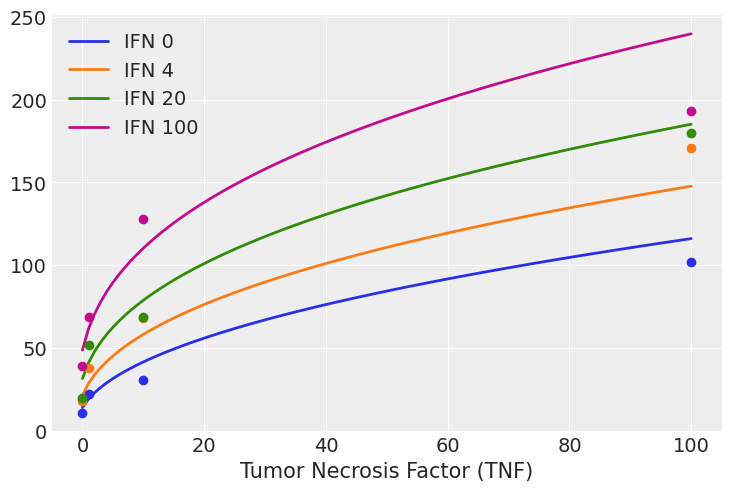

In [18]:
fig, ax = plt.subplots()

for i, (ifn, mu) in enumerate(zip(ifn_vals, mu_pred)):
    ax.plot(tnf_vals, mu, label=f"IFN {ifn}", color=f"C{i}", lw=2)

for i, ifn in enumerate(ifn_vals):
    data_ = data[data["IFN"] == ifn]
    plt.plot(data_["TNF"], data_["y"], "o", color=f"C{i}")
    
ax.set_xlabel("Tumor Necrosis Factor (TNF)")
ax.legend(loc="upper left");

https://stats.stackexchange.com/questions/1444/how-should-i-transform-non-negative-data-including-zeros

In [19]:
model_3 = bmb.Model("y ~ np.arcsinh(TNF)*np.arcsinh(IFN)", data, family="negativebinomial")
model_3

Formula: y ~ np.arcsinh(TNF)*np.arcsinh(IFN)
Family name: Negativebinomial
Link: log
Observations: 16
Priors:
  Intercept ~ Normal(mu: 4.32661302, sigma: 2.18875886)
  np.arcsinh(TNF) ~ Normal(mu: 0, sigma: 0.49090805)
  np.arcsinh(IFN) ~ Normal(mu: 0, sigma: 0.45535411)
  np.arcsinh(TNF):np.arcsinh(IFN) ~ Normal(mu: 0, sigma: 0.1506351)
  alpha ~ HalfCauchy(beta: 1)

In [20]:
fitted_3 = model_3.fit(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_alpha, np.arcsinh(TNF):np.arcsinh(IFN), np.arcsinh(IFN), np.arcsinh(TNF), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


In [21]:
b_0 = fitted_3.posterior["Intercept"].squeeze().values.reshape(-1,)
b_tnf = fitted_3.posterior["np.arcsinh(TNF)"].squeeze().values.reshape(-1,)
b_ifn = fitted_3.posterior["np.arcsinh(IFN)"].squeeze().values.reshape(-1,)
b_tnf_ifn = fitted_3.posterior["np.arcsinh(TNF):np.arcsinh(IFN)"].squeeze().values.reshape(-1,)

In [22]:
y_hat = []
tnf_vals = np.arange(0, 101)
ifn_vals = np.array([0, 4, 20, 100])

for idx, ifn in enumerate(ifn_vals):
    new_data = pd.DataFrame({"TNF": tnf_vals, "IFN": np.array([ifn] * len(tnf_vals))})
    X = model_3._design.common._evaluate_new_data(new_data).design_matrix
    y_hat.append(np.exp(np.dot(X, np.vstack([b_0, b_tnf, b_ifn, b_tnf_ifn]))))

mu_pred = [y.mean(1) for y in y_hat]

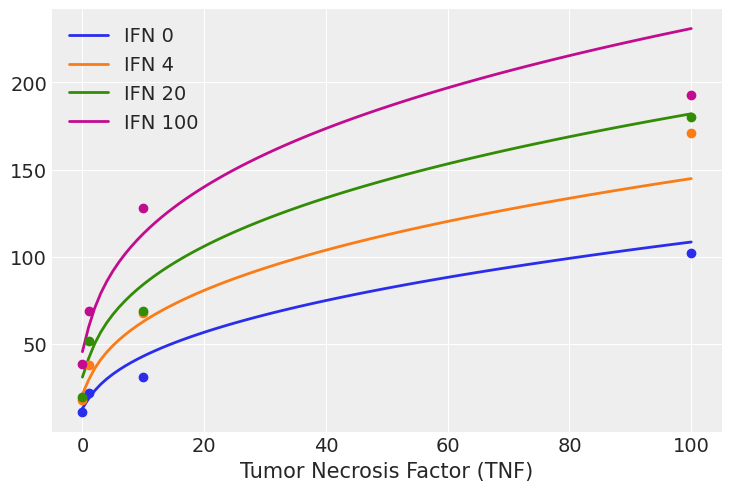

In [23]:
fig, ax = plt.subplots()

for i, (ifn, mu) in enumerate(zip(ifn_vals, mu_pred)):
    ax.plot(tnf_vals, mu, label=f"IFN {ifn}", color=f"C{i}", lw=2)

for i, ifn in enumerate(ifn_vals):
    data_ = data[data["IFN"] == ifn]
    plt.plot(data_["TNF"], data_["y"], "o", color=f"C{i}")
    
ax.set_xlabel("Tumor Necrosis Factor (TNF)")
ax.legend(loc="upper left");

In [24]:
models = {"scaled": fitted, "log + 1": fitted_2, "arcsinh": fitted_3}
df_compare = az.compare(models)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


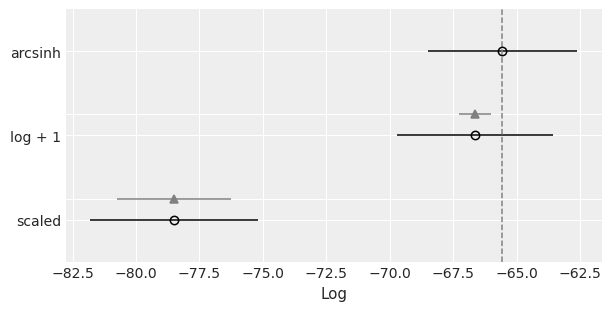

In [25]:
az.plot_compare(df_compare, insample_dev=False);

Comment

* Mention that we use the `.evaluate_new_data()` method from formulae, which is not exposed yet. Explain a little how this is so good.
* The first fit is poor.
* Try to remove the interaction and see what happens.
* More work to do?

Problem

* The maximum number for the predi must be 200 (given by the data) and the model is not seeing that